<div style="text-align:center"><img src="https://pas-wordpress-media.s3.us-east-1.amazonaws.com/content/uploads/2015/12/loan-e1450497559334.jpg" /></div>


<h1 style="font-family:verdana;"> <center>💸 Loan Prediction Analysis 💸</center> </h1>

<h2 style="font-family:verdana;"> <center>🚩 Problem Statement </center> </h2>
<center> The goal of this project is to predict whether a loan applicant will be approved or not based on various features such as credit score, income, loan amount, etc.</center>

* [Data Preprocessing](#section-one)
* [ML Models for Loan Prediction](#section-two)
* [Feature Importance](#section-three)

In [53]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier


In [37]:
train = pd.read_csv(r"/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv")

In [38]:
print (train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<a id="section-one"></a>
# Data Pre-Processing

In [39]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Treating Missing Values

In [40]:
train_null = train.isnull().sum().sort_values(ascending=False)
train_null.head(10)

Credit_History      50
Self_Employed       32
LoanAmount          22
Dependents          15
Loan_Amount_Term    14
Gender              13
Married              3
Loan_ID              0
Education            0
ApplicantIncome      0
dtype: int64

The dataset contains numerous columns with a substantial number of empty fields. Simply deleting the corresponding rows would result in a significant reduction in the size of our training dataset, which would negatively impact our model's performance. To handle this issue, we utilize null value treatment methods such as replacing these empty fields with either the Mean or Mode of the column values. Since the majority of our columns are binary, we find that replacing empty fields with the Mode value is the most effective approach. However, for the LoanAmount column, which is not a categorical variable, we replace empty fields with the Mean value.

In [41]:
train['Credit_History'] = train['Credit_History'].fillna( train['Credit_History'].dropna().mode().values[0])
train['Self_Employed'] = train['Self_Employed'].fillna( train['Self_Employed'].dropna().mode().values[0])
train['LoanAmount'] = train['LoanAmount'].fillna( train['LoanAmount'].dropna().mean())
train['Dependents'] = train['Dependents'].fillna( train['Dependents'].dropna().mode().values[0])
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].fillna( train['Loan_Amount_Term'].dropna().mode().values[0])
train['Gender'] = train['Gender'].fillna( train['Gender'].dropna().mode().values[0])
train['Married'] = train['Married'].fillna( train['Married'].dropna().mode().values[0])

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Handling Categorical Variables

*Let's look at the unique values of each categorical variable*

In [43]:
for i in train.columns:
    if train[i].dtypes == object and i != 'Loan_ID':
        print(i, ":  ",train[i].unique())

Gender :   ['Male' 'Female']
Married :   ['No' 'Yes']
Dependents :   ['0' '1' '2' '3+']
Education :   ['Graduate' 'Not Graduate']
Self_Employed :   ['No' 'Yes']
Property_Area :   ['Urban' 'Rural' 'Semiurban']
Loan_Status :   ['Y' 'N']


In [44]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


*Map these categories to their binary alternative*

In [45]:
train['Loan_Status'] = train['Loan_Status'].map({'N':0, 'Y':1}).astype(int)
train = pd.get_dummies(train, columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'])

#Normalized Numeric Values
standardScaler = StandardScaler()
col_to_scale = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
train[col_to_scale] = standardScaler.fit_transform(train[col_to_scale])

### Creating Train and Test Dataset

In [46]:
y = train['Loan_Status']
X = train.drop(['Loan_Status', 'Loan_ID'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [47]:
X_train.shape, X_test.shape

((491, 20), (123, 20))

<a id="section-two"></a>
# ML Models for Loan Prediction

### 1. XGBOOST

In [61]:
gbm_param_grid = {
    'n_estimators': range(1,1000,10),
    'max_depth': range(1,20),
    'learning_rate': [.1, .4, .45, .5, .55, .61],
    'colsample_bytree': [.6, .7, .8, .9, 1],
}

xgb_classifier = XGBClassifier()
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid,
                                estimator= xgb_classifier, scoring = "accuracy",
                                verbose = 0, n_iter = 100, cv = 4)

xgb_random.fit(X_train, y_train)
print(f'Best parameters: {xgb_random.best_params_}')

y_pred = xgb_random.predict(X_test)
print(f'Accuracy: {np.sum(y_pred==y_test)/len(y_test)}')

Best parameters: {'n_estimators': 21, 'max_depth': 1, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.7886178861788617


The final binary classification accuracy is around 78.9%

### 2. Decision Tree

In [50]:
param_grid = {
    'max_depth': range(4,20),
    'min_samples_leaf': range(10,100,10),
    'min_samples_split': range(10,100, 10),
    'criterion':['gini', 'entropy']
}
n_folds = 5

dt = DecisionTreeClassifier(random_state=np.random.randint(0,100))
dt_grid = GridSearchCV(dt, param_grid, cv = n_folds, return_train_score=True, verbose=0)
dt_grid.fit(X_train, y_train)
print(dt_grid.best_params_)

y_pred_best = dt_grid.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred_best)
print(acc)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 10}
0.7804878048780488


The test accuracy is 78.04%, which is worse that XGBoost

### 3. Random Forest Classifier

In [65]:
rf_param_grid = {
    'n_estimators': range(1,1000, 100)
}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(param_distributions=rf_param_grid, estimator = rf, scoring = "accuracy", verbose = 0 , n_iter = 10, cv = 4)
rf_random.fit(X_train, y_train)
best_params = rf_random.best_params_
print(f'Best parameters: {best_params}')

y_pred1 = rf_random.predict(X_test)
print(f'Accuracy: {np.sum(y_pred1==y_test)/len(y_test)}')


Best parameters: {'n_estimators': 401}
Accuracy: 0.7723577235772358


The accuracy of this test is 77%, which is worst than both tests above. 

### 4. Support Vector Classifier (SVC)

In [64]:
svm_param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': range(1,11)
}

svm = SVC()

svm_random = RandomizedSearchCV(param_distributions=svm_param_grid, estimator = svm, scoring = "accuracy",
                               verbose = 0, n_iter = 40, cv = 4)

svm_random.fit(X_train, y_train)
best_params = svm_random.best_params_
print(f'Best parameters: {best_params}')

y_pred_best = svm_random.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred_best)
print(acc)

Best parameters: {'kernel': 'linear', 'C': 1}
0.7886178861788617


The accuracy of this test is 78.86%. We can conclude that SVM and XGBoost are two best performing ML models for performing loan prediction.


<a id="section-three"></a>
# Feature Importance

In [58]:
def feature_imp(df, model):
    feat = pd.DataFrame(columns= ['feature', 'importance'])
    feat['feature'] = df.columns
    feat['importance'] = model.best_estimator_.feature_importances_
    return feat.sort_values(by="importance", ascending = False)

### XGBoost

<AxesSubplot:ylabel='feature'>

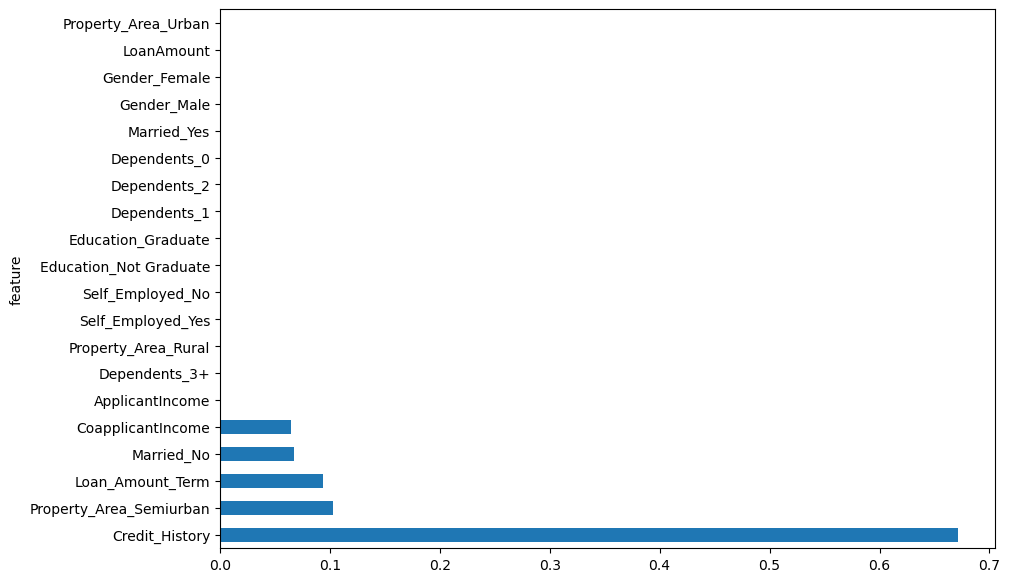

In [62]:
feature_imp(X_train, xgb_random).plot('feature', 'importance', 'barh', figsize=(10,7), legend = False)

Credit history greatly influence the final decision.

### Decision Tree

<AxesSubplot:ylabel='feature'>

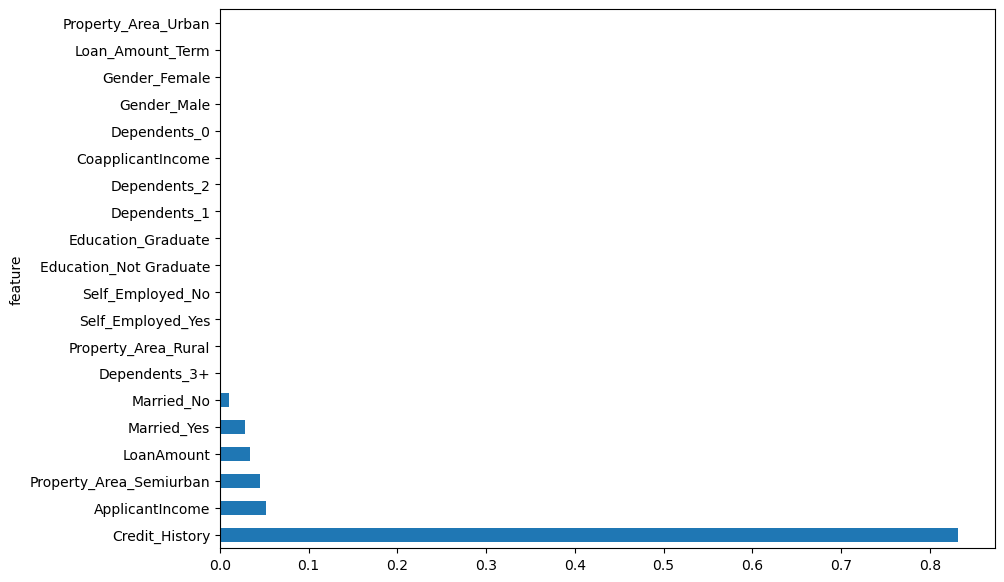

In [59]:
feature_imp(X_train, dt_grid).plot('feature', 'importance', 'barh', figsize=(10,7), legend = False)

Credit history greatly influence the final decision.

### Random Forest

<AxesSubplot:ylabel='feature'>

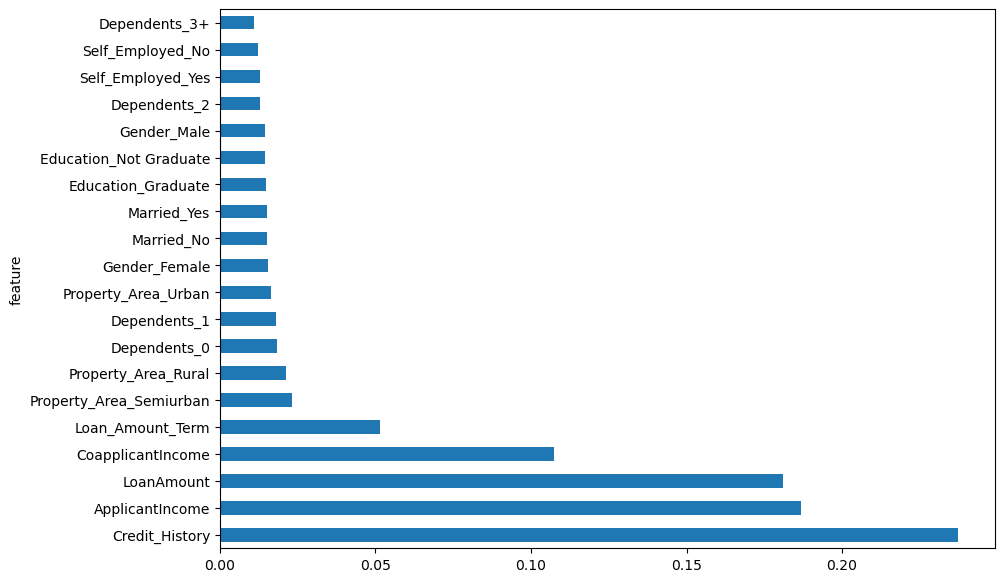

In [60]:
feature_imp(X_train, rf_random).plot('feature', 'importance', 'barh', figsize=(10,7), legend = False)

Credit history, loan amount, and applicant income greatly influence the final decision.